In [1]:
import sys
sys.executable



'/opt/homebrew/opt/python@3.11/bin/python3.11'

In [7]:
!{sys.executable} -m pip install seaborn scipy


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from ast import literal_eval
from scipy import stats

In [10]:
users = pd.read_csv("/Users/samsanovicekaterina/dl.25/data/users.tsv", sep="\t")
history = pd.read_csv("/Users/samsanovicekaterina/dl.25/data/history.tsv", sep="\t")
validate = pd.read_csv("/Users/samsanovicekaterina/dl.25/data/validate.tsv", sep="\t")
answers = pd.read_csv("/Users/samsanovicekaterina/dl.25/data/validate_answers.tsv", sep="\t")


In [11]:
users.head()


,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4


In [12]:
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27769 entries, 0 to 27768
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  27769 non-null  int64
 1   sex      27769 non-null  int64
 2   age      27769 non-null  int64
 3   city_id  27769 non-null  int64
dtypes: int64(4)
memory usage: 867.9 KB


In [13]:
users.describe(include="all")

,user_id,sex,age,city_id
count,27769.000000,27769.000000,27769.000000,27769.000000
mean,13884.000000,1.475134,28.894847,240.141165
std,8016.364149,0.501549,18.510084,466.122195
min,0.000000,0.000000,0.000000,0.000000
25%,6942.000000,1.000000,18.000000,0.000000
50%,13884.000000,1.000000,27.000000,25.000000
75%,20826.000000,2.000000,36.000000,231.000000
max,27768.000000,2.000000,118.000000,2456.000000


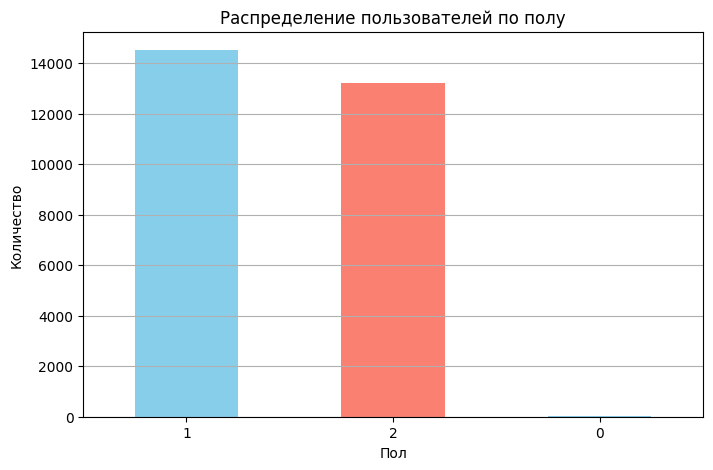

In [14]:
plt.figure(figsize=(8, 5))
users["sex"].value_counts().plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Распределение пользователей по полу")
plt.xlabel("Пол")
plt.ylabel("Количество")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

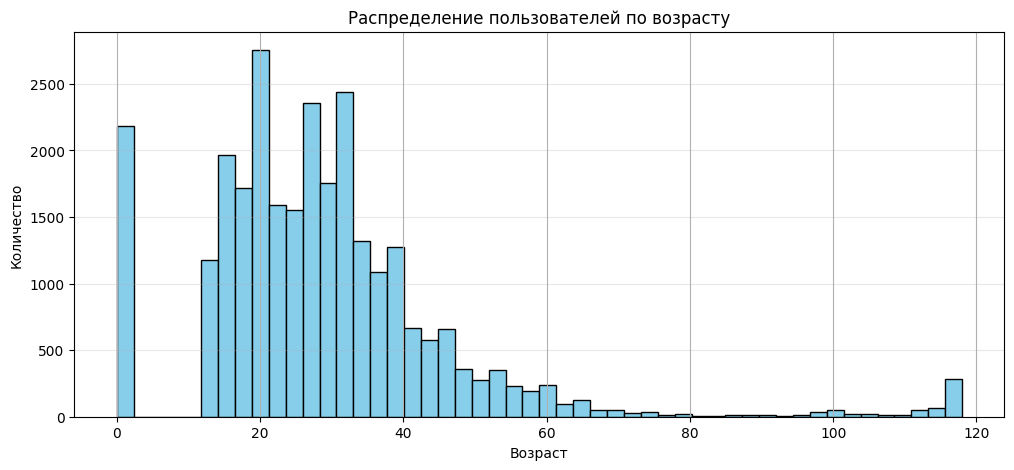

Пользователей с возрастом 0: 2180
Средний возраст (исключая 0): 31.36
Медианный возраст (исключая 0): 28.00


In [ ]:
plt.figure(figsize=(12, 5))
users["age"].hist(bins=50, edgecolor="black", color="skyblue")
plt.title("Распределение пользователей по возрасту")
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.grid(axis="y", alpha=0.3)
plt.show()

age_non_zero = users[users["age"] > 0]["age"]
print(f"Пользователей с возрастом 0: {(users['age'] == 0).sum()}")
print(f"Средний возраст (исключая 0): {age_non_zero.mean():.2f}")
print(f"Медианный возраст (исключая 0): {age_non_zero.median():.2f}")

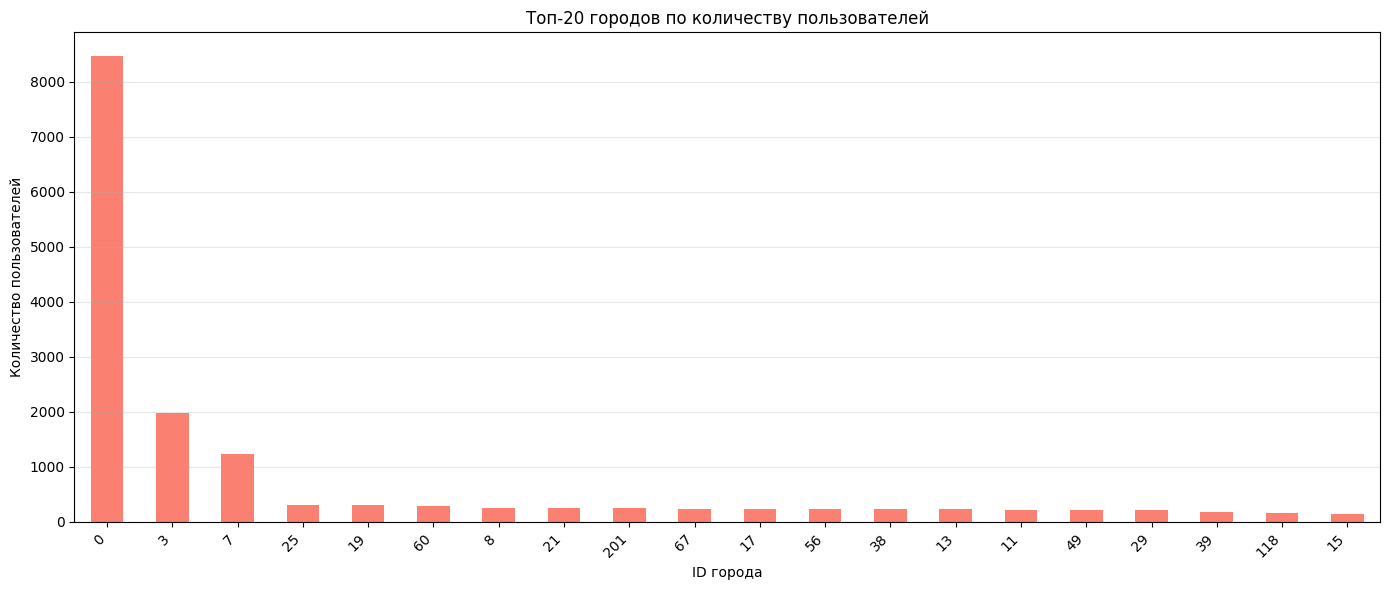

Всего уникальных городов: 2457
Городов с одним пользователем: 1365


In [17]:
plt.figure(figsize=(14, 6))
top_cities = users["city_id"].value_counts().head(20)
top_cities.plot(kind="bar", color="salmon")
plt.title("Топ-20 городов по количеству пользователей")
plt.xlabel("ID города")
plt.ylabel("Количество пользователей")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Всего уникальных городов: {users['city_id'].nunique()}")
print(f"Городов с одним пользователем: {(users['city_id'].value_counts() == 1).sum()}")

User - все признаки представлены целочисленными значениями, nan нет.

категориальные признаки - user id, sex(два значения - one_hot подойдет/эмбедиинг небольшой размерности),

age вообще числовой, но здесь nan заменяется 0, поэтому будет некорректно использовать его как чисто числовой признак,

city_id - числовой порядок значений не имеет семантического смысла, поэтому данный признак также требует представления в виде эмбеддингов.


In [18]:
history.head()

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148


In [19]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147857 entries, 0 to 1147856
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   hour       1147857 non-null  int64  
 1   cpm        1147857 non-null  float64
 2   publisher  1147857 non-null  int64  
 3   user_id    1147857 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 35.0 MB


In [20]:
history.describe()

,hour,cpm,publisher,user_id
count,1.147857e+06,1.147857e+06,1.147857e+06,1.147857e+06
mean,7.603016e+02,1.864043e+02,2.004760e+00,1.384739e+04
std,4.306159e+02,4.557257e+02,2.061949e+00,8.028620e+03
min,3.000000e+00,3.000000e+01,1.000000e+00,0.000000e+00
25%,3.920000e+02,5.500000e+01,1.000000e+00,6.817000e+03
50%,7.620000e+02,1.100000e+02,1.000000e+00,1.394100e+04
75%,1.138000e+03,2.100000e+02,2.000000e+00,2.075900e+04
max,1.490000e+03,2.090540e+05,2.100000e+01,2.776800e+04


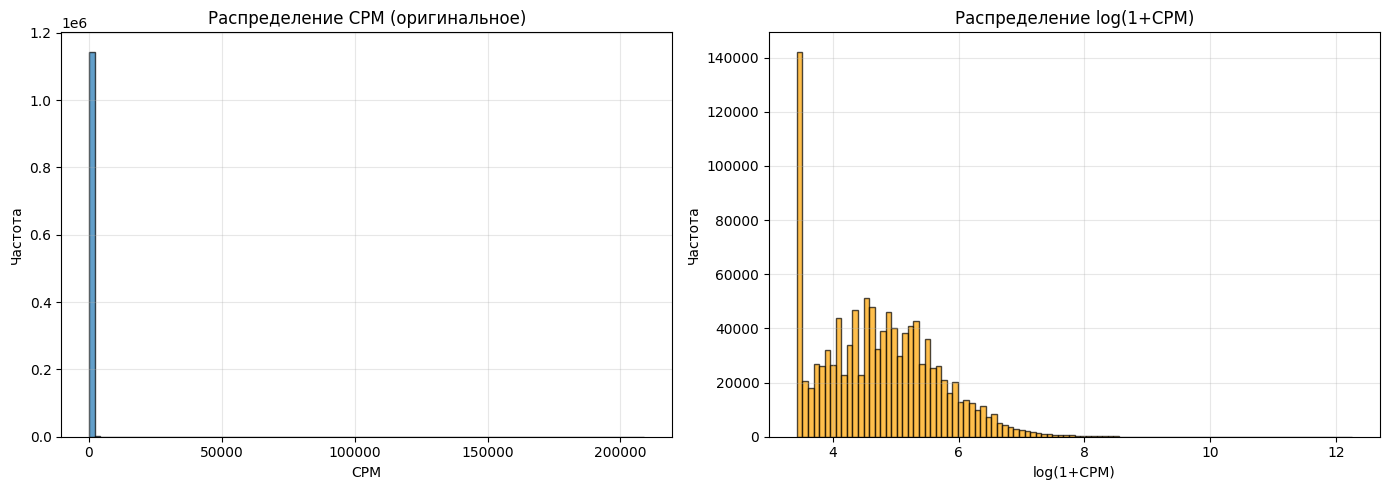

Статистика CPM:
Среднее: 186.40
Медиана: 110.00
Стандартное отклонение: 455.73
Минимум: 30.00
Максимум: 209053.98


In [21]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(history["cpm"], bins=100, edgecolor="black", alpha=0.7)
axes[0].set_title("Распределение CPM (оригинальное)")
axes[0].set_xlabel("CPM")
axes[0].set_ylabel("Частота")
axes[0].grid(alpha=0.3)
cpm_log = np.log1p(history["cpm"])
axes[1].hist(cpm_log, bins=100, edgecolor="black", alpha=0.7, color="orange")
axes[1].set_title("Распределение log(1+CPM)")
axes[1].set_xlabel("log(1+CPM)")
axes[1].set_ylabel("Частота")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Статистика CPM:")
print(f"Среднее: {history['cpm'].mean():.2f}")
print(f"Медиана: {history['cpm'].median():.2f}")
print(f"Стандартное отклонение: {history['cpm'].std():.2f}")
print(f"Минимум: {history['cpm'].min():.2f}")
print(f"Максимум: {history['cpm'].max():.2f}")

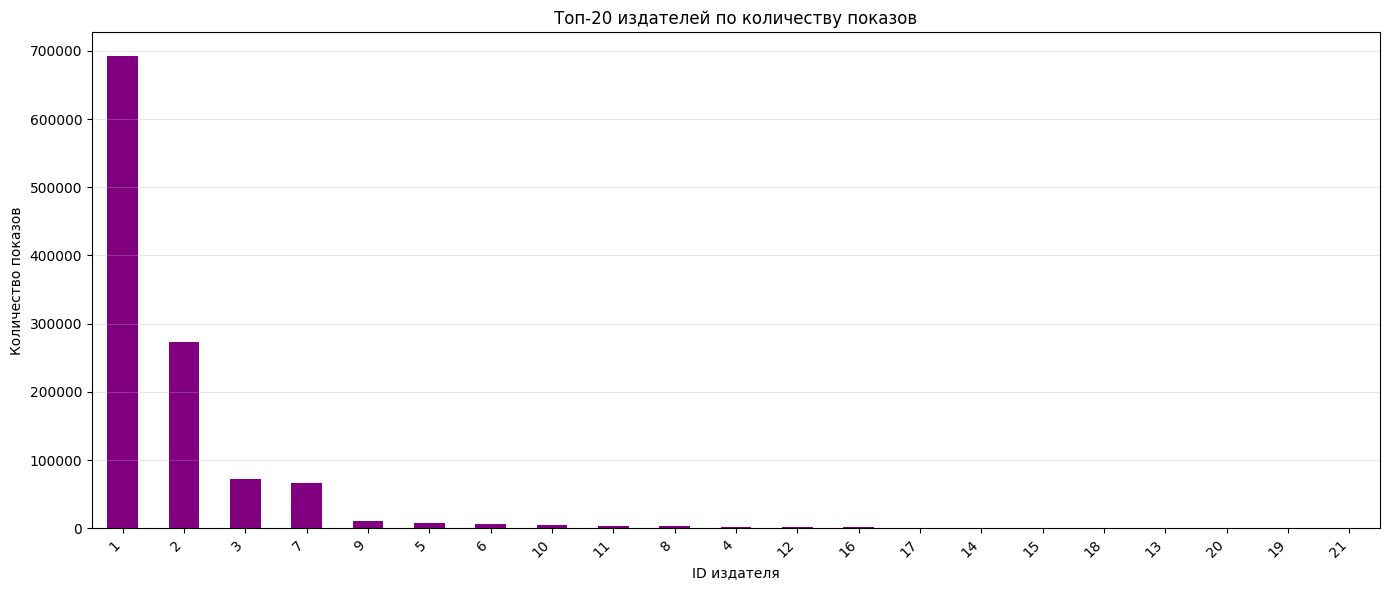

Всего уникальных издателей: 21
Доля показов от топ-10 издателей: 99.24%


In [22]:
plt.figure(figsize=(14, 6))
top_publishers = history["publisher"].value_counts()
top_publishers.plot(kind="bar", color="purple")
plt.title("Топ-20 издателей по количеству показов")
plt.xlabel("ID издателя")
plt.ylabel("Количество показов")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Всего уникальных издателей: {history['publisher'].nunique()}")
print(f"Доля показов от топ-10 издателей: {history['publisher'].value_counts().head(10).sum() / len(history) * 100:.2f}%")

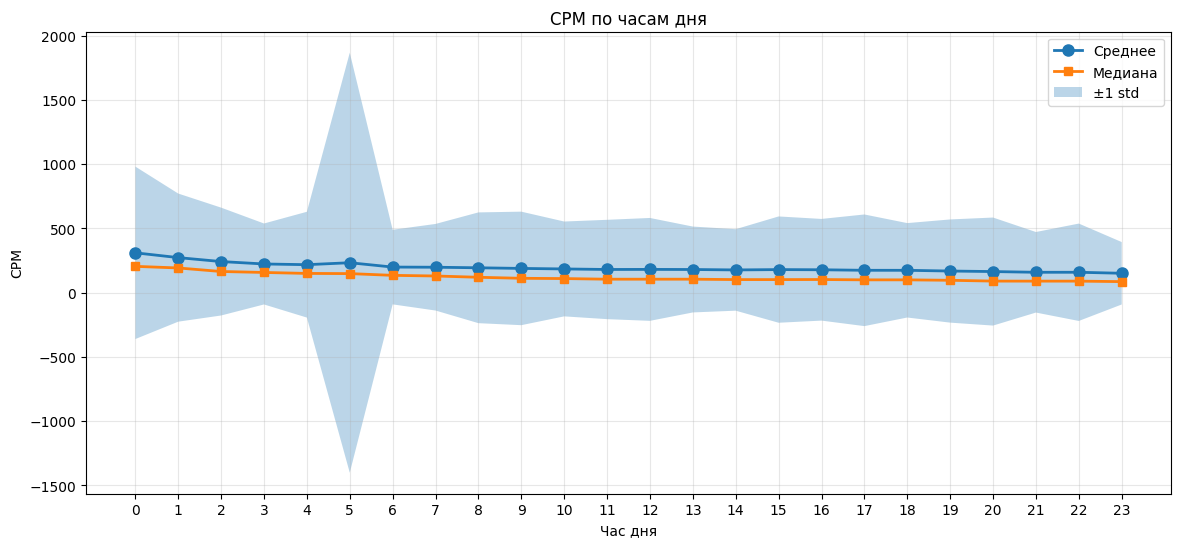

In [23]:
history["hour_of_day"] = history["hour"] % 24
hour_cpm = history.groupby("hour_of_day")["cpm"].agg(["mean", "median", "std"])
plt.figure(figsize=(14, 6))
plt.plot(hour_cpm.index, hour_cpm["mean"], marker="o", linewidth=2, markersize=8, label="Среднее")
plt.plot(hour_cpm.index, hour_cpm["median"], marker="s", linewidth=2, markersize=6, label="Медиана")
plt.fill_between(hour_cpm.index, 
                 hour_cpm["mean"] - hour_cpm["std"], 
                 hour_cpm["mean"] + hour_cpm["std"], 
                 alpha=0.3, label="±1 std")
plt.title("CPM по часам дня")
plt.xlabel("Час дня")
plt.ylabel("CPM")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(range(24))
plt.show()

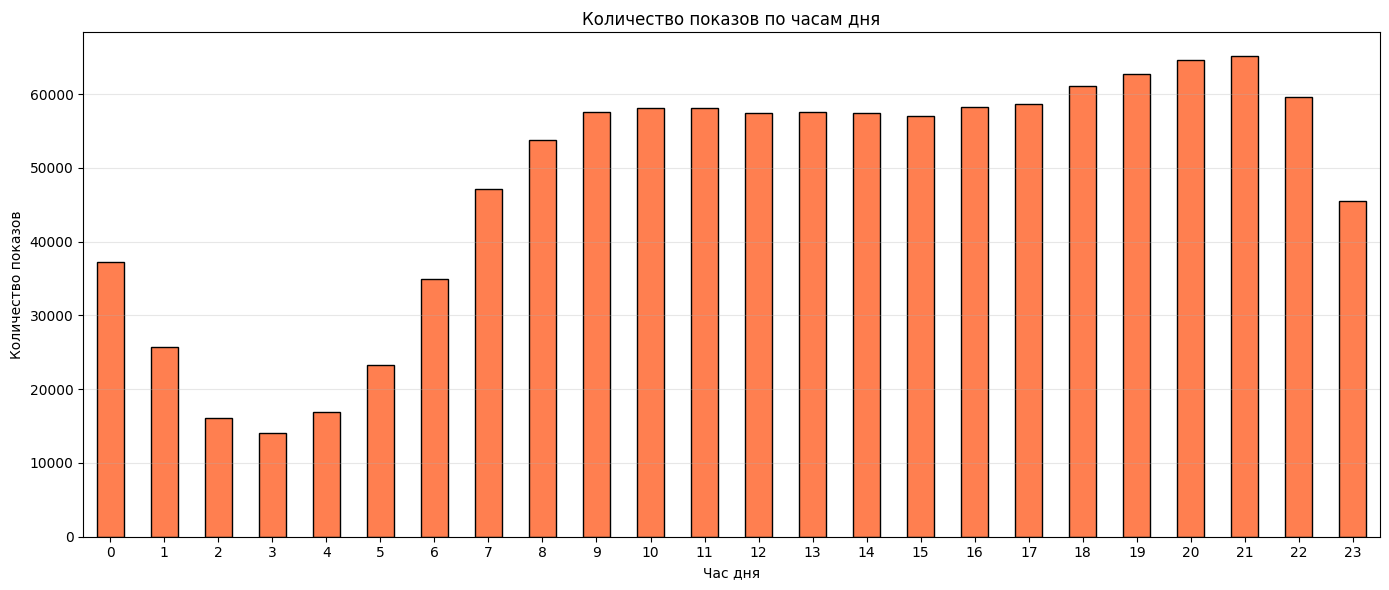

In [24]:
plt.figure(figsize=(14, 6))
impressions_by_hour = history["hour_of_day"].value_counts().sort_index()
impressions_by_hour.plot(kind="bar", color="coral", edgecolor="black")
plt.title("Количество показов по часам дня")
plt.xlabel("Час дня")
plt.ylabel("Количество показов")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

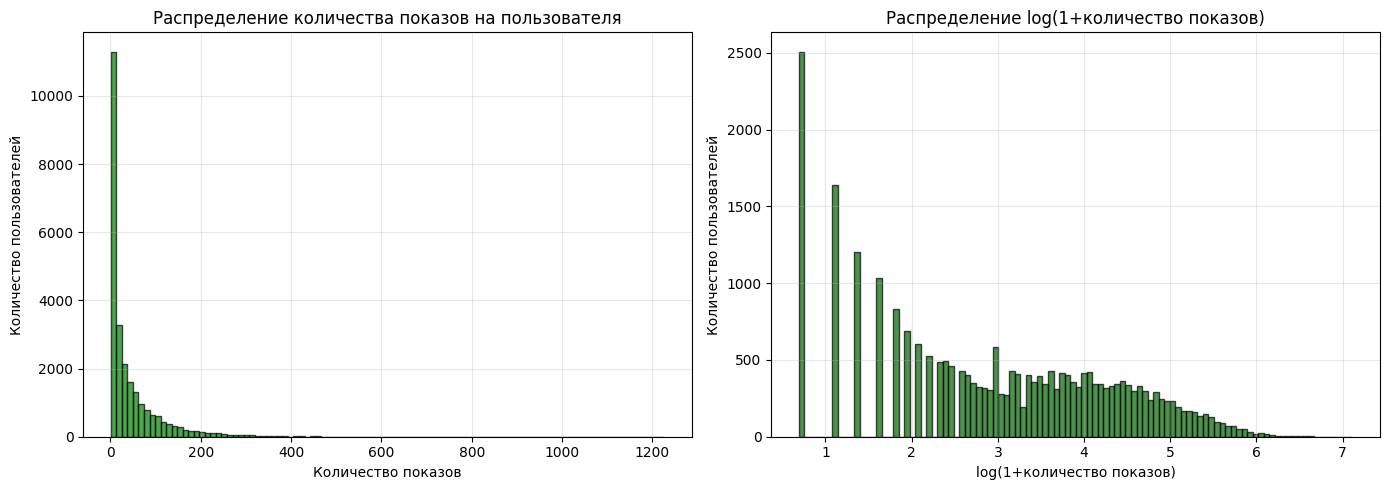

Статистика показов на пользователя:
Среднее: 44.95
Медиана: 18.00
Максимум: 1226
Пользователей с 1 показом: 2508
Пользователей с >100 показами: 3470


In [25]:
user_impressions = history["user_id"].value_counts()
plt.figure(figsize=(14, 6))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(user_impressions, bins=100, edgecolor="black", alpha=0.7, color="green")
axes[0].set_title("Распределение количества показов на пользователя")
axes[0].set_xlabel("Количество показов")
axes[0].set_ylabel("Количество пользователей")
axes[0].grid(alpha=0.3)

axes[1].hist(np.log1p(user_impressions), bins=100, edgecolor="black", alpha=0.7, color="darkgreen")
axes[1].set_title("Распределение log(1+количество показов)")
axes[1].set_xlabel("log(1+количество показов)")
axes[1].set_ylabel("Количество пользователей")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Статистика показов на пользователя:")
print(f"Среднее: {user_impressions.mean():.2f}")
print(f"Медиана: {user_impressions.median():.2f}")
print(f"Максимум: {user_impressions.max()}")
print(f"Пользователей с 1 показом: {(user_impressions == 1).sum()}")
print(f"Пользователей с >100 показами: {(user_impressions > 100).sum()}")

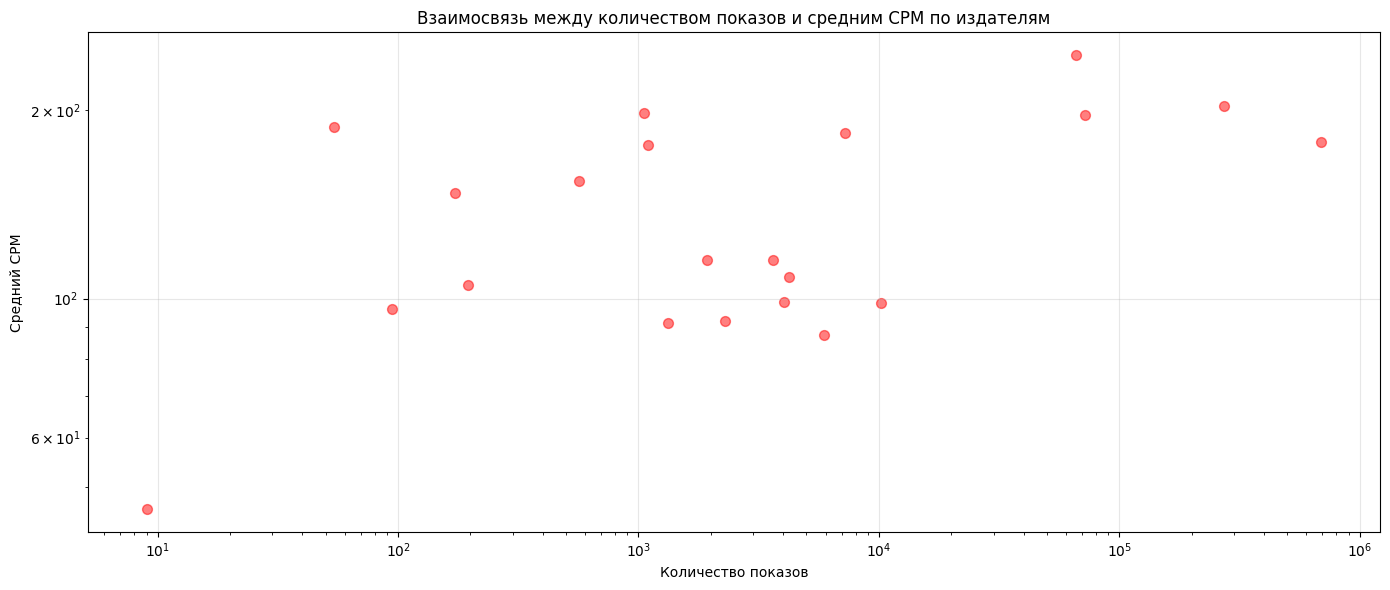

In [26]:
publisher_stats = history.groupby("publisher").agg({
    "cpm": ["mean", "median", "count"]
}).reset_index()
publisher_stats.columns = ["publisher", "mean_cpm", "median_cpm", "impression_count"]

plt.figure(figsize=(14, 6))
plt.scatter(publisher_stats["impression_count"], 
           publisher_stats["mean_cpm"], 
           alpha=0.5, s=50, color="red")
plt.xlabel("Количество показов")
plt.ylabel("Средний CPM")
plt.title("Взаимосвязь между количеством показов и средним CPM по издателям")
plt.xscale("log")
plt.yscale("log")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

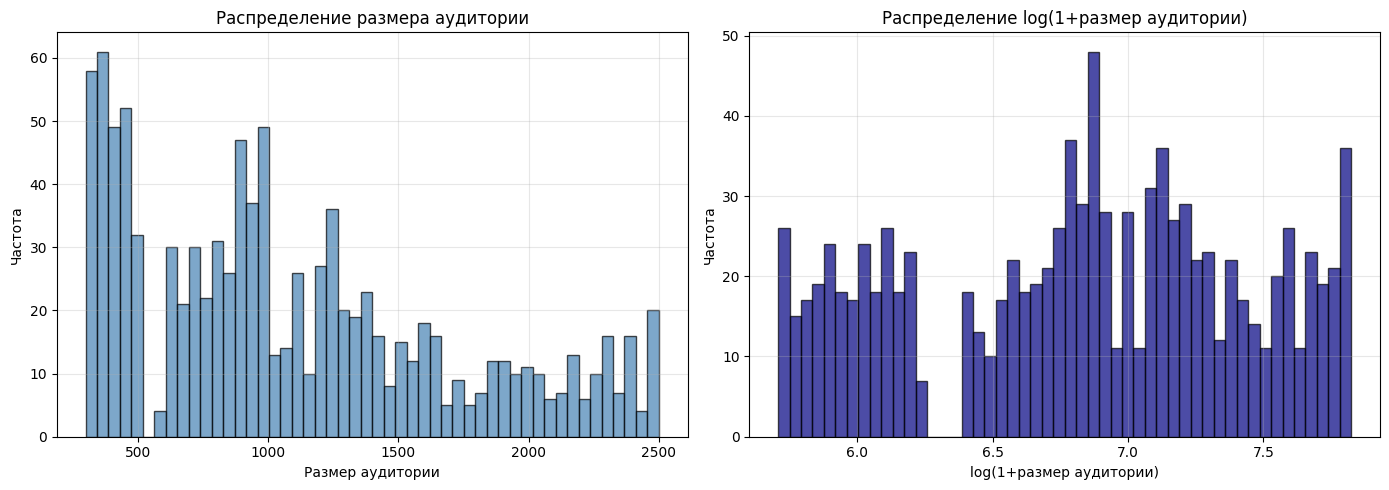

Статистика размера аудитории:
Среднее: 1090.09
Медиана: 960.00
Минимум: 300
Максимум: 2500


In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(validate["audience_size"], bins=50, edgecolor="black", alpha=0.7, color="steelblue")
axes[0].set_title("Распределение размера аудитории")
axes[0].set_xlabel("Размер аудитории")
axes[0].set_ylabel("Частота")
axes[0].grid(alpha=0.3)

axes[1].hist(np.log1p(validate["audience_size"]), bins=50, edgecolor="black", alpha=0.7, color="navy")
axes[1].set_title("Распределение log(1+размер аудитории)")
axes[1].set_xlabel("log(1+размер аудитории)")
axes[1].set_ylabel("Частота")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Статистика размера аудитории:")
print(f"Среднее: {validate['audience_size'].mean():.2f}")
print(f"Медиана: {validate['audience_size'].median():.2f}")
print(f"Минимум: {validate['audience_size'].min()}")
print(f"Максимум: {validate['audience_size'].max()}")

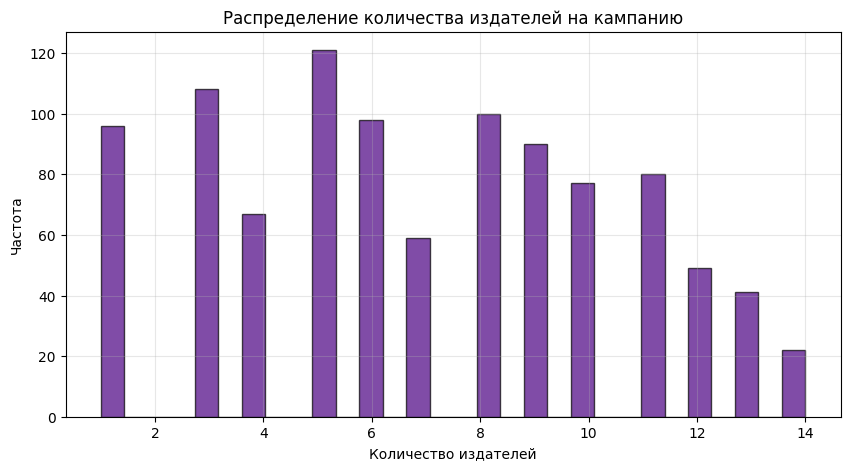

Среднее количество издателей на кампанию: 6.93
Медианное количество издателей: 7.00
Минимум: 1
Максимум: 14


In [28]:
validate["num_publishers"] = validate["publishers"].apply(len)
plt.figure(figsize=(10, 5))
validate["num_publishers"].hist(bins=30, edgecolor="black", alpha=0.7, color="indigo")
plt.title("Распределение количества издателей на кампанию")
plt.xlabel("Количество издателей")
plt.ylabel("Частота")
plt.grid(alpha=0.3)
plt.show()

print(f"Среднее количество издателей на кампанию: {validate['num_publishers'].mean():.2f}")
print(f"Медианное количество издателей: {validate['num_publishers'].median():.2f}")
print(f"Минимум: {validate['num_publishers'].min()}")
print(f"Максимум: {validate['num_publishers'].max()}")

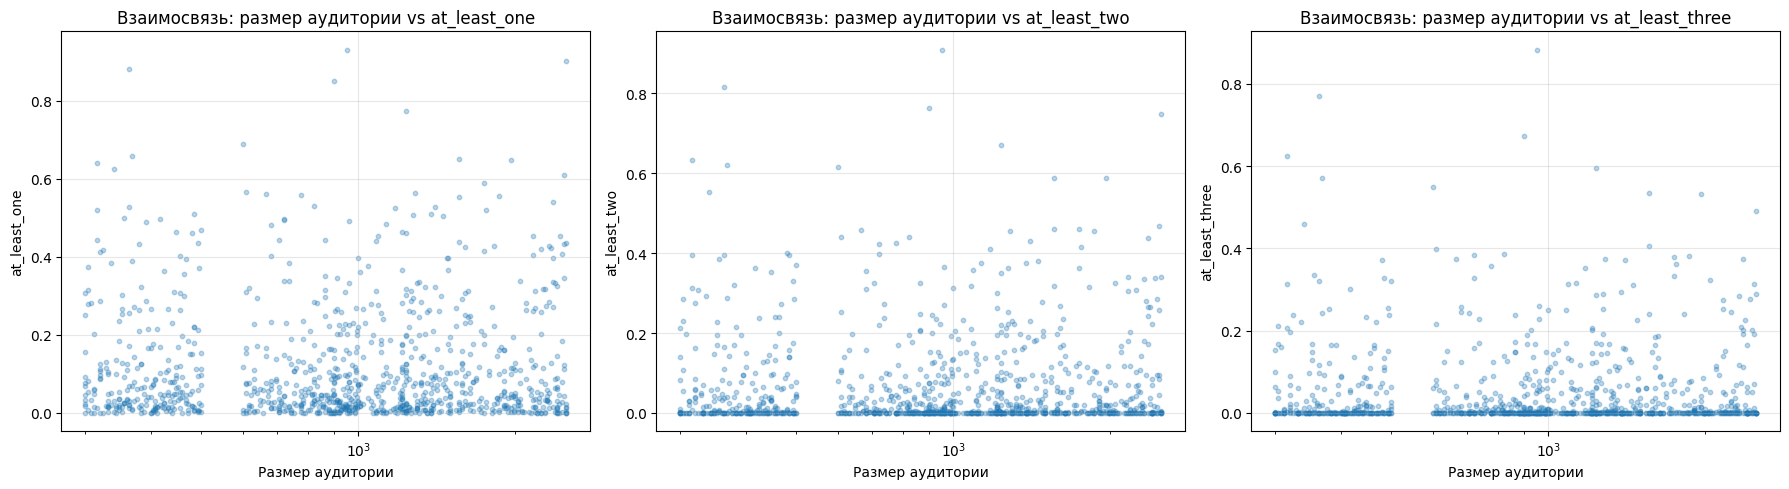

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(answers.columns):
    axes[idx].scatter(validate["audience_size"], answers[col], alpha=0.3, s=10)
    axes[idx].set_xlabel("Размер аудитории")
    axes[idx].set_ylabel(col)
    axes[idx].set_title(f"Взаимосвязь: размер аудитории vs {col}")
    axes[idx].set_xscale("log")
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

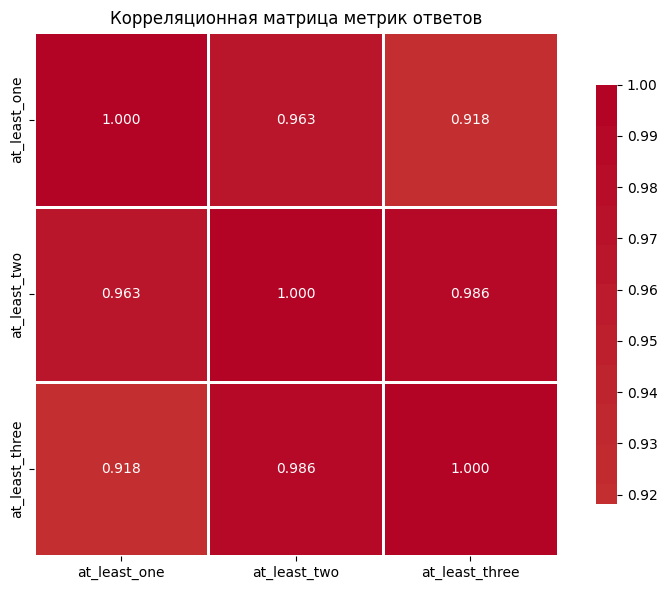

In [30]:

plt.figure(figsize=(8, 6))
correlation_matrix = answers.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap="coolwarm", center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Корреляционная матрица метрик ответов")
plt.tight_layout()
plt.show()

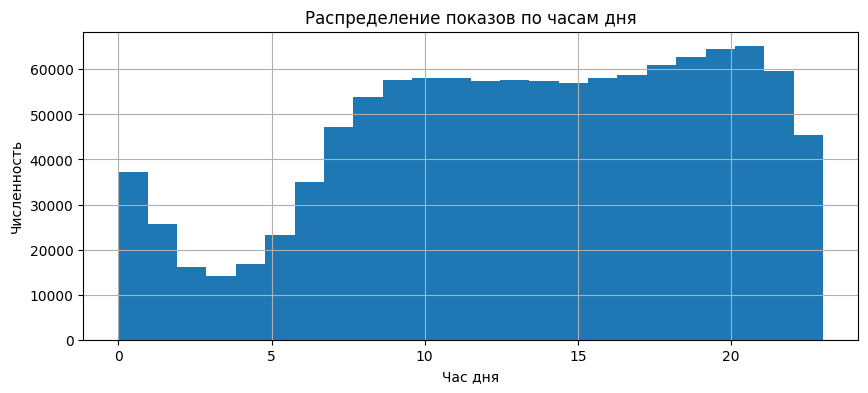

In [33]:
history["hour_of_day"] = history["hour"] % 24
plt.figure(figsize=(10,4))
history["hour_of_day"].hist(bins=24)
plt.title("Распределение показов по часам дня")
plt.xlabel("Час дня")
plt.ylabel("Численность")
plt.show()


history.tsv - история показов рекламных объявлений пользователям за два последовательных месяца.

Признаки: hour - временную компоненту показа, нельзя интерпретировать как независимую категориальную или числовую величину без учёта порядка и относительного положения во времени,

cpm - стоимость показа рекламного объявления в аукционе, высокая дисперсия, надо будет логарифмировать или нормализовывать.

publisher - категориальный идентификатор рекламной площадки. Нет порядкового смысла, поэтому рассматривается как категориальный и предполагает embedding.

In [10]:
validate.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1..."
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3..."
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5..."
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524..."
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2..."


In [11]:
validate[["publishers", "user_ids"]].iloc[0]

,0
publishers,"7,17"
user_ids,"12,44,46,50,58,71,93,122,134,143,176,184,187,1..."


In [12]:
validate["publishers"] = validate["publishers"].apply(literal_eval)
validate["user_ids"] = validate["user_ids"].apply(literal_eval)

In [13]:
validate["audience_size"].describe()

,audience_size
count,1008.000000
mean,1090.087302
std,613.557243
min,300.000000
25%,575.000000
50%,960.000000
75%,1464.000000
max,2500.000000


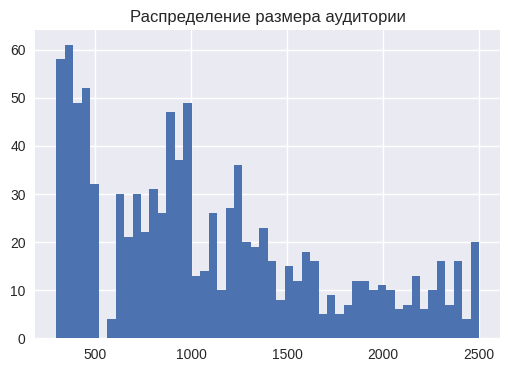

In [18]:
plt.figure(figsize=(6,4))
validate["audience_size"].hist(bins=50)
plt.title("Распределение размера аудитории")
plt.show()

In [19]:
answers.describe()

,at_least_one,at_least_two,at_least_three
count,1008.000000,1008.000000,1008.000000
mean,0.115441,0.065805,0.047170
std,0.146146,0.117812,0.099029
min,0.000000,0.000000,0.000000
25%,0.016650,0.000000,0.000000
50%,0.055250,0.009800,0.001400
75%,0.158700,0.078125,0.048950
max,0.930700,0.909700,0.883400


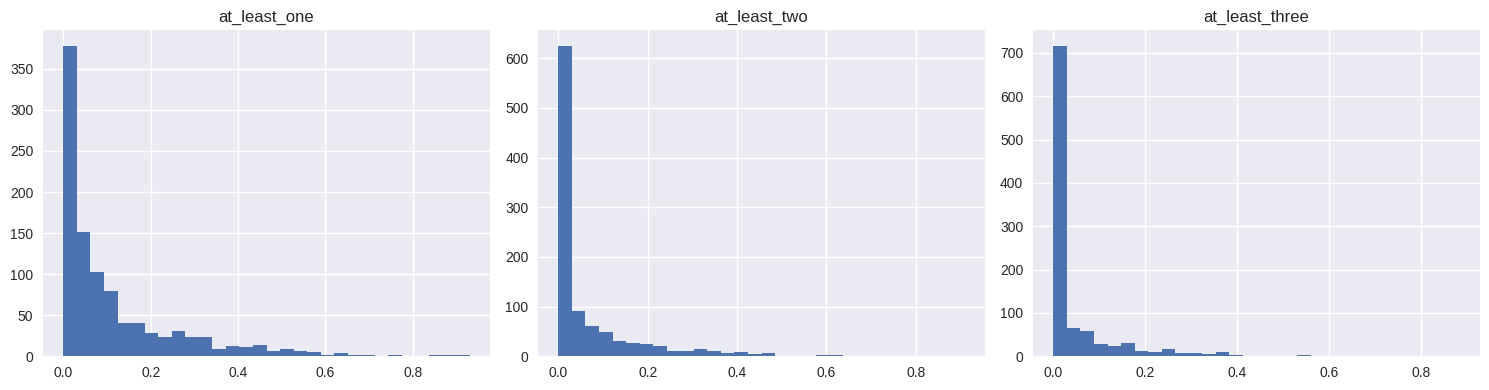

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

for ax, col in zip(axes, answers.columns):
    answers[col].hist(bins=30, ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()


Здесь мы видим плавное убывание: большинство кампаний имеют относительно малую долю пользователей, которые увидят рекламу многократно, и лишь небольшая часть кампаний достигает высокой доли.

Это отражает естественную особенность аукциона: чем больше количество повторных показов, тем меньше пользователей охватывается.

In [21]:
violations = (
    (answers["at_least_three"] > answers["at_least_two"]) |
    (answers["at_least_two"] > answers["at_least_one"])
)

violations.sum()


np.int64(0)

Проверка корректности данных - если пользователь увидел объявление 3 раза, то он точно видел его и 1, и 2 раза


In [34]:
history_users = set(history["user_id"])
validate_users = set(u for users_list in validate["user_ids"] for u in users_list)

len(validate_users - history_users), len(validate_users)


(11, 11)

Всего пользователей в целевом наборе (`validate`) — 27 769.

Пользователей, которых нет в истории показов (`history`) — 2 233.

Это означает, что около 8% пользователей целевого набора не имеют исторических данных. Для этих пользователей нужно будет использовать или отдельный embedding для "нового пользователя" или заполнять агрегаты по истории средними значениями.


Проблема холодного старта

In [35]:
warm_users = set(history["user_id"].unique())
all_users = set(users["user_id"].unique())

cold_users = all_users - warm_users

print(f"Всего пользователей: {len(all_users)}")
print(f"Warm users (с историей): {len(warm_users)}")
print(f"Cold users (без истории): {len(cold_users)}")
users["is_cold"] = users["user_id"].apply(lambda x: x in cold_users)


Всего пользователей: 27769
Warm users (с историей): 25536
Cold users (без истории): 2233


In [36]:
sex_table = pd.crosstab(users["sex"], users["is_cold"])
chi2, p_value, _, _ = stats.chi2_contingency(sex_table)
print("Проверка различий по полу (хи^2 тест)")
print(f"p-value = {p_value:.5f}")
n = sex_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(sex_table.shape) - 1)))
print(f"Cramer’s V = {cramers_v:.4f}")

Проверка различий по полу (хи^2 тест)
p-value = 0.00000
Cramer’s V = 0.0803


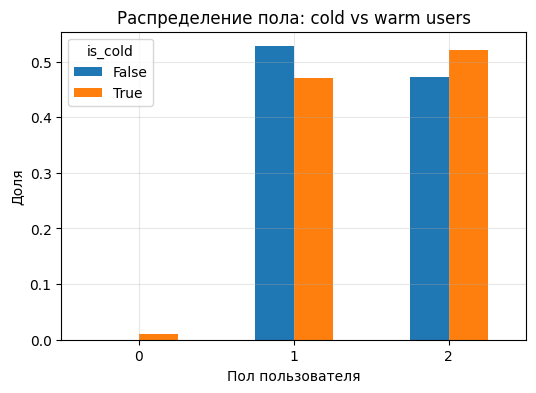

In [38]:
sex_share = sex_table.div(sex_table.sum(axis=0), axis=1)
sex_share.plot(kind="bar", figsize=(6, 4))
plt.title("Распределение пола: cold vs warm users")
plt.ylabel("Доля")
plt.xlabel("Пол пользователя")
plt.xticks(rotation=0)
plt.grid(alpha=0.3)
plt.show()


хи^2-тест показал статистически значимые различия по полу между cold и warm пользователями (p < 0.001). При этом размер эффекта по Cramer’s V равен 0.08, что соответствует слабой зависимости. Это указывает на ограниченную, но ненулевую информативность признака пола для cold-start прогнозирования.

Изучим зависимость с географией пользователей

In [39]:
top_cities = users["city_id"].value_counts().head(10).index
users_city = users[users["city_id"].isin(top_cities)]

city_table = pd.crosstab(users_city["city_id"], users_city["is_cold"])
chi2, p_value, _, _ = stats.chi2_contingency(city_table)

print("Проверка различий по городам (хи^2 тест, топ-10)")
print(f"p-value = {p_value:.5f}")
n = city_table.sum().sum()
cramers_v_city = np.sqrt(chi2 / (n * (min(city_table.shape) - 1)))

print(f"Cramer’s V = {cramers_v_city:.4f}")



Проверка различий по городам (хи^2 тест, топ-10)
p-value = 0.00000
Cramer’s V = 0.1020


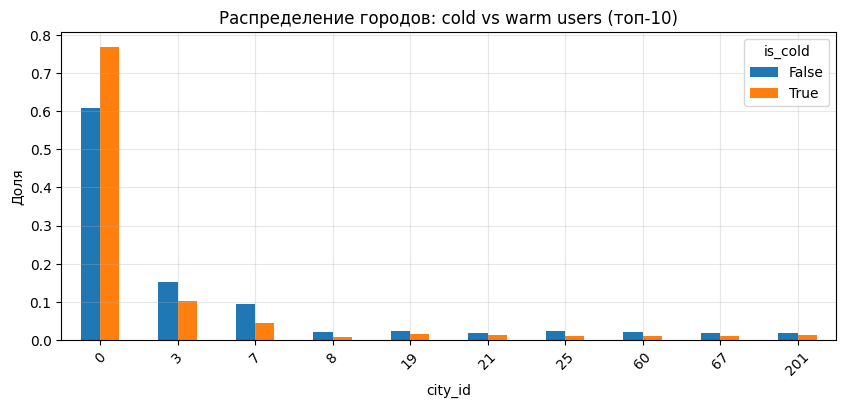

In [40]:
city_share = city_table.div(city_table.sum(axis=0), axis=1)

city_share.plot(kind="bar", figsize=(10, 4))
plt.title("Распределение городов: cold vs warm users (топ-10)")
plt.ylabel("Доля")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()


География является одним из наиболее информативных демографических признаков для cold-start, однако её вклад не слишком велик и требует комбинирования с другими признаками.